<a href="https://colab.research.google.com/github/antonkozhukhov/breeds/blob/main/dog_vision_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!unzip 'drive/MyDrive/dog-vision/dog-breed-identification.zip' -d 'drive/MyDrive/dog-vision/'

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__)

2.12.0


In [3]:
print(hub.__version__)

0.13.0


In [4]:
print("Yes" if tf.config.list_physical_devices("GPU") else "no")

Yes


## Continue

In [5]:
import pandas as pd
labels = pd.read_csv('drive/MyDrive/dog-vision/labels.csv')
print(labels.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


In [6]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


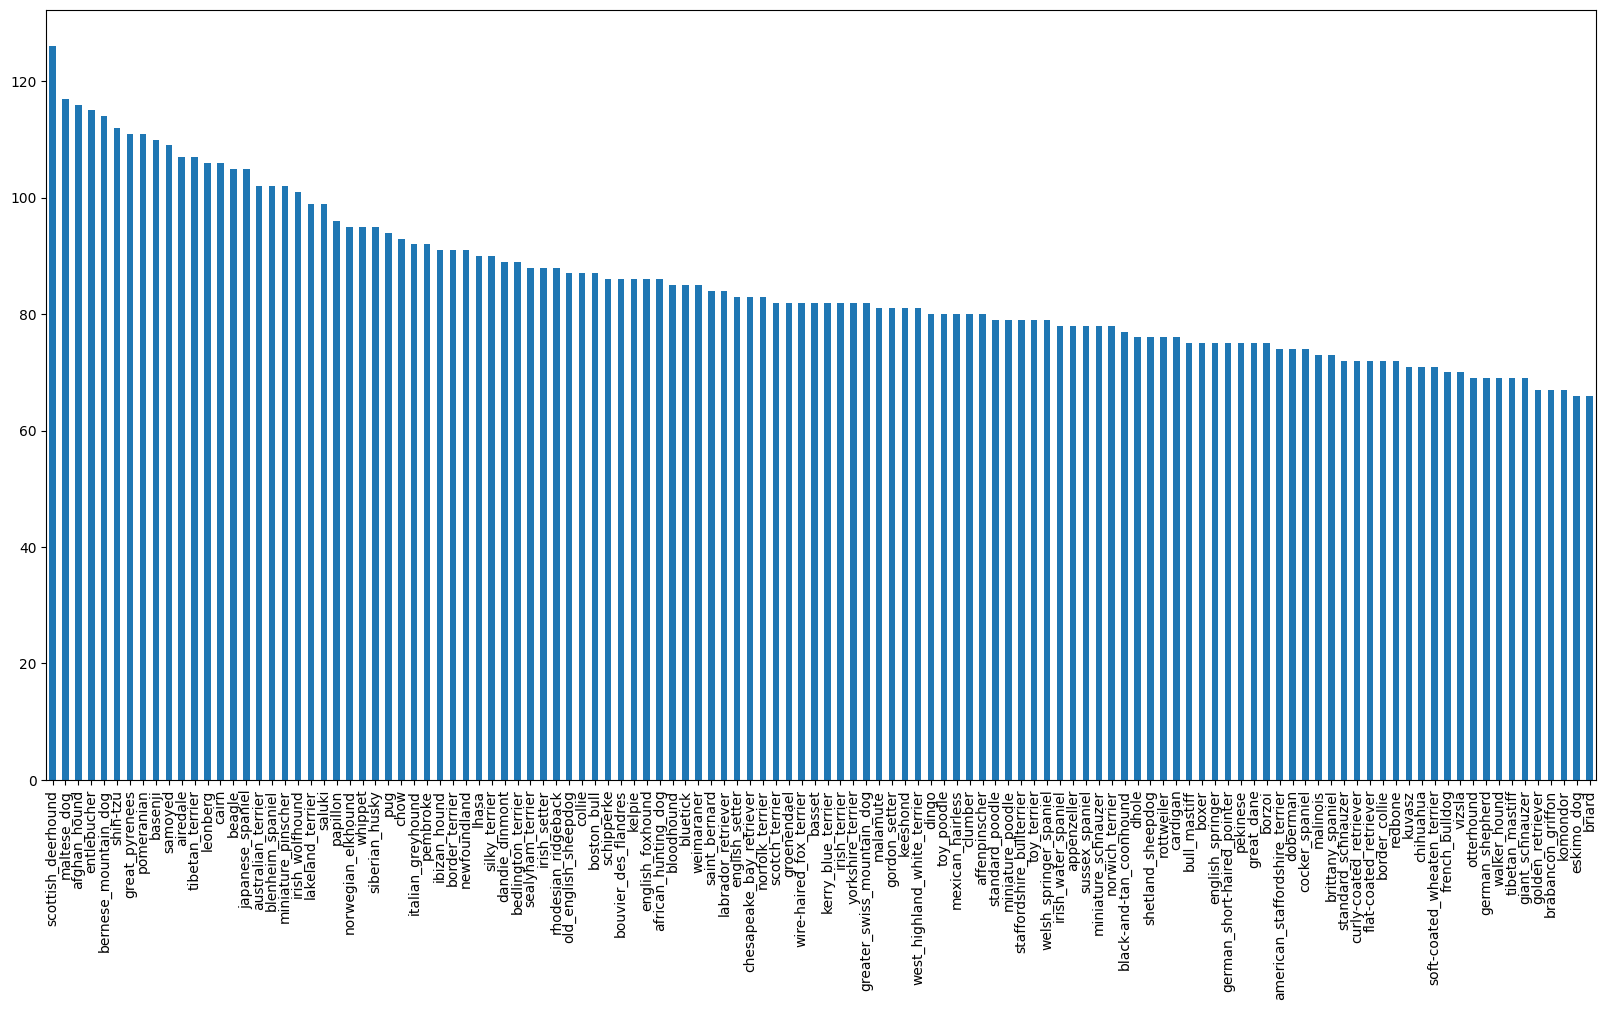

In [7]:
labels['breed'].value_counts().plot.bar(figsize=(20,10));

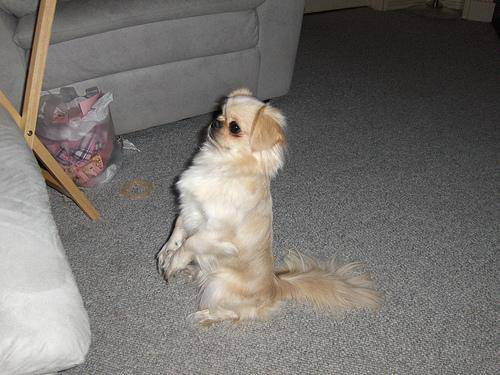

In [8]:
import IPython
from IPython.display import Image
Image('drive/MyDrive/dog-vision/train/001cdf01b096e06d78e9e5112d419397.jpg')

In [9]:
path = 'drive/MyDrive/dog-vision/train/'
filenames = [path+fname+'.jpg' for fname in labels.id]

In [10]:
filenames;

In [11]:
import os
if len(os.listdir('drive/MyDrive/dog-vision/train/'))==len(filenames):
  print("yes")
else: print("no") 

yes


In [12]:
import numpy as np
unique_labels = np.unique(labels['breed'])




In [13]:
labs = labels['breed'].to_numpy()
boolen_labels = [lab == unique_labels for lab in labs]

In [14]:
len(boolen_labels)

10222

In [15]:
boolen_labels2 = [boolen_labels[t].astype(int).argmax() for t in range(len(boolen_labels))]

In [16]:
boolen_labels2[:10]

[19, 37, 85, 15, 49, 10, 10, 18, 7, 97]

In [17]:
X = filenames

In [18]:
y = boolen_labels

In [19]:
NUM_IMAGES = 7000 #@param {type:'slider', min:1000, max:10000,step:100}


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],y[:NUM_IMAGES],
                                                  test_size=0.2, random_state=42)

In [21]:
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [22]:
tf.constant(image);

In [23]:
IMG_SIZE = 224

def process_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [24]:
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

In [25]:
(process_image(X[42]),y[42]);

In [26]:
BATCH_SIZE = 32

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  if test_data:
    print("creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  elif valid_data:
    print("creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  else:
    print("creating train data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
  return data_batch

In [27]:
train_data = create_data_batches(X_train,y_train)
val_data = create_data_batches(X_val,y_val,valid_data=True)

creating train data batches...
creating validation data batches...


In [29]:
train_data.element_spec, val_data.element_spec 

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [31]:
import matplotlib.pyplot as plt
def show_25_images(images, labels):
  plt.figure(figsize=(10, 10))
  for i in range(25):
   ax = plt.subplot(5, 5, i+1) 
   plt.imshow(images[i])
   plt.title(unique_labels[boolen_labels[i].argmax()])
   plt.axis('off') 

In [32]:
train_images, train_labels = next(train_data.as_numpy_iterator())

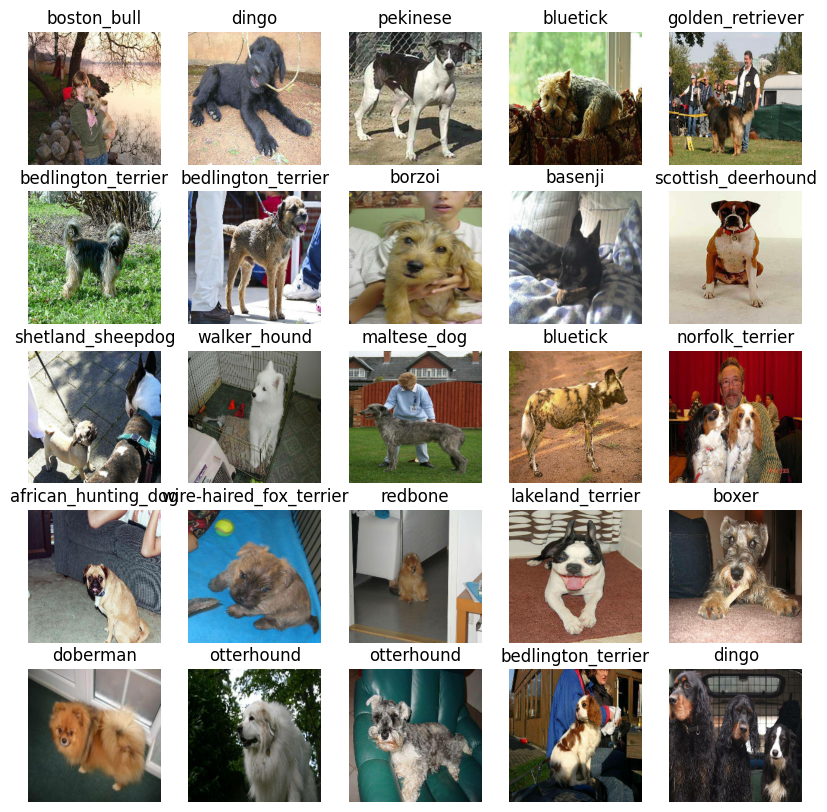

In [33]:
show_25_images(train_images, train_labels)

In [34]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

In [35]:
OUTPUT_SHAPE = len(unique_labels)

In [36]:
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5'

In [37]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("bulding a model with:", MODEL_URL)
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL),
      tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax") 
  ])
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )
  model.build(INPUT_SHAPE)
  return model

In [38]:
#model = create_model()
#model.summary()

In [39]:
%load_ext tensorboard
import datetime
def create_tensorboard_callback():
  logdir = os.path.join('drive/MyDrive/dog-vision/logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

In [41]:
NUM_EPOCHS = 100 #@param {type:'slider', min:10, max:100,step:10}

In [42]:
def train_model():
  model = create_model()
  tensorboard = create_tensorboard_callback()
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks = [tensorboard, early_stopping])
  return model

def save_model(model, suffix=None):
  modeldir = os.path.join('drive/MyDrive/dog-vision/model',
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir+"-"+suffix+".h5"
  print("saving model...")
  model.save(model_path)
  return(model_path)
  
def load_model(model_path):
  print("loading model...")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [43]:
model = train_model()
path = save_model(model, suffix="dogs_5steps")

bulding a model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
175/175 [==============================] - 160s 759ms/step - loss: 1.8057 - accuracy: 0.5836 - val_loss: 0.8535 - val_accuracy: 0.7536
Epoch 2/100
175/175 [==============================] - 24s 137ms/step - loss: 0.4449 - accuracy: 0.8821 - val_loss: 0.7353 - val_accuracy: 0.7736
Epoch 3/100
175/175 [==============================] - 22s 126ms/step - loss: 0.2400 - accuracy: 0.9463 - val_loss: 0.7259 - val_accuracy: 0.7736
Epoch 4/100
175/175 [==============================] - 25s 143ms/step - loss: 0.1494 - accuracy: 0.9702 - val_loss: 0.7172 - val_accuracy: 0.7814
Epoch 5/100
175/175 [==============================] - 25s 140ms/step - loss: 0.0968 - accuracy: 0.9864 - val_loss: 0.7205 - val_accuracy: 0.7929
Epoch 6/100
175/175 [==============================] - 23s 130ms/step - loss: 0.0682 - accuracy: 0.9941 - val_loss: 0.7251 - val_accuracy: 0.7893
Epoch 7/100
175/175 [========

In [44]:
#load_model = load_model(path)

In [45]:
#path = save_model(model, suffix="dogs_5steps")